In [11]:
library(car)
library(MASS)
library(rms)
library(glmnet)
library(leaps)
require(ggplot2)
set.seed(1234)

Loading required package: carData
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘rms’

The following objects are masked from ‘package:car’:

    Predict, vif

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



# Part III Final Model & Outliers

### 3.1 Final model description

We choose weight and abdomen as predictiors for body fat as our final model.

In [7]:
fat.rm = read.csv("../data/clean_fat.csv", header = T)
fat.rm$DENSITY = NULL
fat.rm$IDNO = NULL

In [8]:
lm.reg=lm(BODYFAT~WEIGHT+ABDOMEN,fat.rm)

As we can see from the result, the coefficients are significant and the adjusted R-squared is 0.7148. 
The estimated model is 

$$\text{BodyFat} = -42.95790 -0.11994 \cdot \text{WEIGHT} + 0.90152 \cdot \text{ABDOMEN} $$

When weight increases one additinal unit(lbs), the bodyfat will decrease 0.11994%. When abdomen increases one additional unit(cm), the bodyfat will increase 0.90152%.

In [46]:
summary(lm.reg)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN, data = fat.rm)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4622  -2.9922   0.0778   2.8872   9.6382 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -40.91570    2.42009 -16.907  < 2e-16 ***
WEIGHT       -0.13965    0.01939  -7.201 7.46e-12 ***
ABDOMEN       0.91756    0.05263  17.435  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.083 on 243 degrees of freedom
Multiple R-squared:  0.7203,	Adjusted R-squared:  0.718 
F-statistic: 312.9 on 2 and 243 DF,  p-value: < 2.2e-16


### 3.2 Advantages and disadvantages

Advantages: The model is very simple since there are only two variables and it is convenient for users to gain their weight and abdomen data.

Disadvantages: Since there are only two variables, we sacrificed some accuracy of this model. Meanwhile, the data of users' abdomen may not be as convenient as variables like height and weight to obtain.

### 3.3 Model Diagnose & Outliers

#### 3.3.1 Assumption diagnose and outlier detection

To futherly estimate our model, we draw plots to check the assumptions and outliers for this model. As we can see from the residuals vs fitted values plot, the assumpiton of equal variance(no megaphone shape) and linearity(no curved shape) have been satisfied. Besides, From the qqplot, we can see that the normality assumption has been satisfied.We also drew Internally studentized residual vs Fitted values and Externally studentized residual vs Fitted values plots and find that there is no significant outlier.

Standardized residuals (Internal studentized residuals):
$$r_i=\frac{e_i}{\widehat{\text{SD}}(e_i)}=\frac{e_i}{\sqrt{\hat{\sigma}^2(1-h_{ii})}}$$
where $e_i = Y_i-\hat{Y}_i$, $H=X(X'X)^{-1}X'$ and $\hat{\sigma}^2=\text{MSE}$.

Studentized residuals (Externally studentized residuals):
$$r_i=\frac{e_i}{\sqrt{\hat{\sigma}^2_{(i)}(1-h_{ii})}}$$

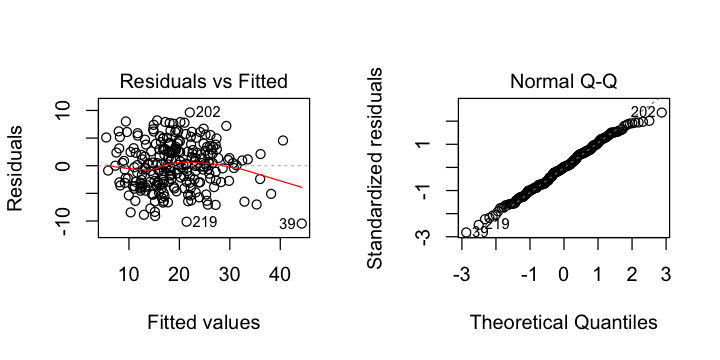

In [24]:
options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
data=fat.rm
plot(lm.reg,1)
plot(lm.reg,2)
index=1:nrow(data)

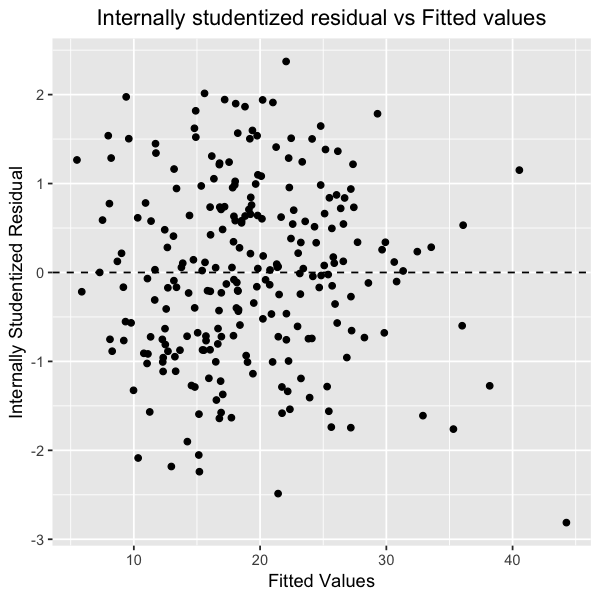

In [35]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot()+
  geom_point(aes(x=lm.reg$fitted,y=stdres(lm.reg)))+
  xlab("Fitted Values")+
  ylab("Internally Studentized Residual")+
  ggtitle("Internally studentized residual vs Fitted values")+
  theme(plot.title = element_text(hjust = 0.5))+
  geom_hline(yintercept = 0, linetype = "dashed")

In [36]:
index[abs(stdres(lm.reg))>3]

integer(0)

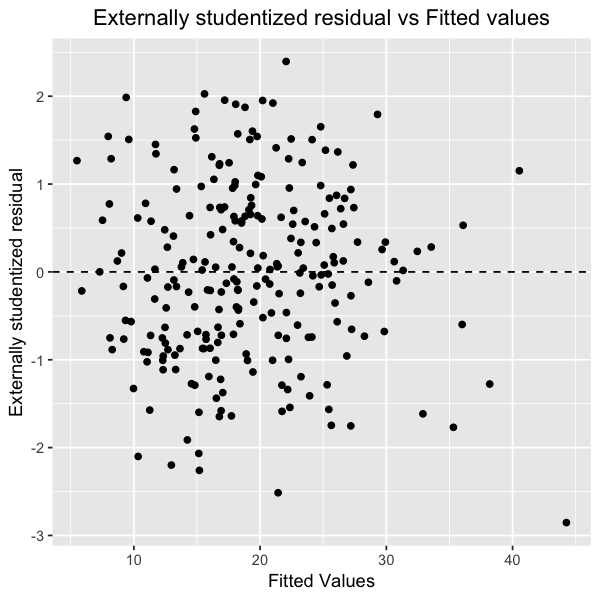

In [37]:
ggplot()+
  geom_point(aes(x=lm.reg$fitted,y=studres(lm.reg)))+
  xlab("Fitted Values")+
  ylab("Externally studentized residual")+
  ggtitle("Externally studentized residual vs Fitted values")+
  theme(plot.title = element_text(hjust = 0.5))+
  geom_hline(yintercept = 0, linetype = "dashed")

In [38]:
index[abs(studres(lm.reg))>3]

integer(0)

#### 3.3.2 Influential points detection

To determine some influential points, we draw Leverage plot, Diffits plot, Cook's distance plot and Debates plot. Aside from Leverage plot, the other three plots does not find influential points. From the Leverage plot, we find 8 influential points(9,12,35,36,152,216,242th). However, there is no enough evidence showing that they are outliers even though they are infulential.

In [39]:
n=nrow(fat.rm)
p=length(coefficients(lm.reg))-1

Leverage (the distance between $X_i$ and the means of the values of $\{X_i\}^n_{i=1}$)
$$h_{ii}=[H]_{ii} \text{ , where } H=X(X'X)^{-1}X'$$
Threshold: rule of thumbL $h_{ii}>4p/n$

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

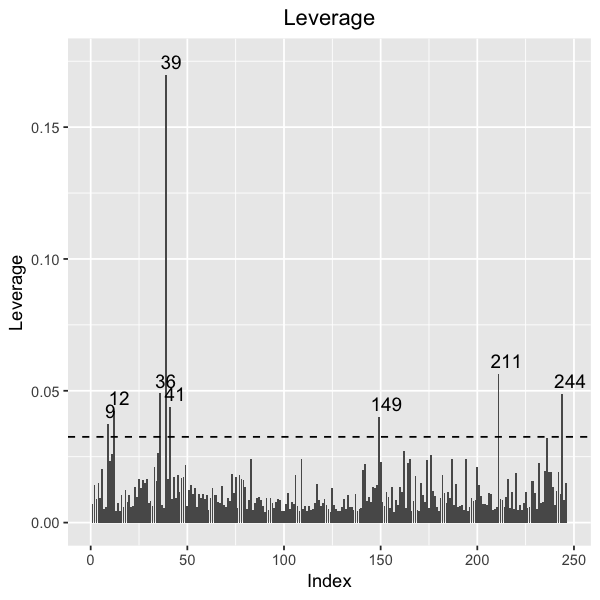

In [40]:
## leverage 
lm.reg.hats = hatvalues(lm.reg)
id_show=which(lm.reg.hats>4*p/n)
ggplot()+
  geom_histogram(aes(x=index,y=lm.reg.hats),stat = "identity")+
  geom_text(aes(x=id_show,y=lm.reg.hats[id_show],
                label=id_show),size = 4,hjust = 0.25, nudge_y = 0.005)+
  xlab("Index")+
  ylab("Leverage")+
  ggtitle("Leverage")+
  theme(plot.title = element_text(hjust = 0.5))+
  geom_hline(yintercept =4*p/n, linetype = "dashed")

DFFITS (influence of the i-th observation on i-th fitted value $\hat{Y}_i$)
$$\text{DFFITS}_i = \frac{\hat{Y}_i-\hat{Y}_{i(i)}}{\hat{\sigma}_{(i)}\sqrt{h_{ii}}}\text{, where i=1,...,n}$$
For datasets of small or medium size,points with value of 1 or greater might be influential. 
For large datasets, the threshold can be $2\sqrt{p/n}$. 
The dataset we used here is not large. Therefore,we choose the threshold 1.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

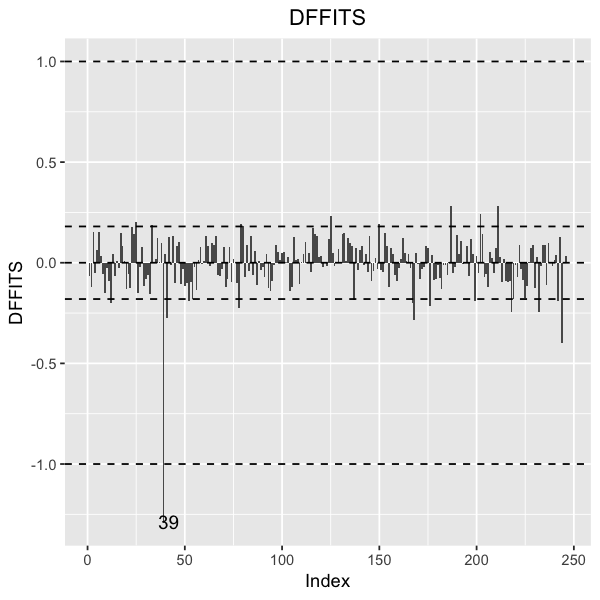

In [43]:
## DFFITS
lm.reg.dffits = dffits(lm.reg)
id_show=which(-lm.reg.dffits>1)
ggplot()+
  geom_histogram(aes(x=index,y=lm.reg.dffits),stat = "identity")+
  geom_text(aes(x=id_show,y=lm.reg.dffits[id_show],
                label=id_show),size = 4,hjust = 0.25, nudge_y = 0.005)+
  xlab("Index")+
  ylab("DFFITS")+
  ggtitle("DFFITS")+
  theme(plot.title = element_text(hjust = 0.5))+
  geom_hline(yintercept =c(-1,-2*sqrt(p/n), 0, 2*sqrt(p/n), 1), linetype = "dashed")

Cook's Distance (the influence of the ith observation on all fitted values)
$$D_i=\frac{\sum_{j=1}^n(\hat{Y}_j-\hat{Y}_{j(i)})^2}{p\hat{\sigma}^2}\text{, where i=1,...,n}$$
Threshold: $F_{p,n-p}$ or simply according to a general rule of thumb: 1

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

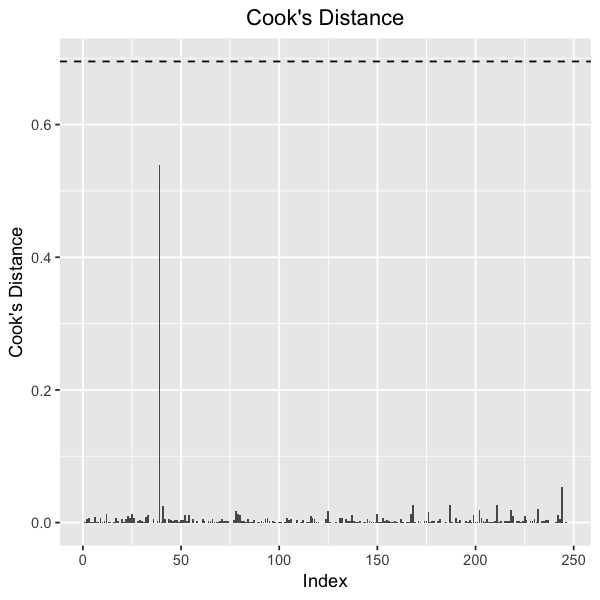

In [44]:
lm.reg.cooksD = cooks.distance(lm.reg)
id_show=which(lm.reg.cooksD>qf(0.50,p,n-p))
ggplot()+
  geom_histogram(aes(x=index,y=lm.reg.cooksD),stat = "identity")+
  geom_text(aes(x=id_show,y=lm.reg.cooksD[id_show],
                label=id_show),size = 4,hjust = 0.25, nudge_y = 0.005)+
  xlab("Index")+
  ylab("Cook's Distance")+
  ggtitle("Cook's Distance")+
  theme(plot.title = element_text(hjust = 0.5))+
  geom_hline(yintercept = qf(0.50,p,n-p), linetype = "dashed")

DFBETAS (the influence of the ith observation on the fitted coefficient $\beta_j$)
$$\text{DFBETAS}_{j(i)}=\frac{\hat{\beta}_j-\hat{\beta}_{j(i)}}{\sqrt{\hat{\sigma}^2_{(i)}(X^T X)^{-1}_{jj}}}\text{, where i=1,...,n,  j=0,...,p-1}$$
Thresholds: $|{\text{DFBETAS}}|\ge 1$ for small or medium datasets; $|{\text{DFBETAS}}|\ge 2/\sqrt{n}$ for large dataset.



Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

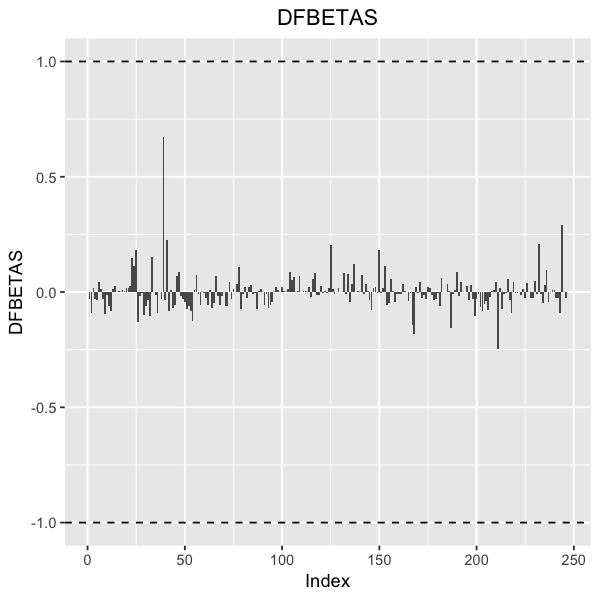

In [45]:
## dfbetas
lm.reg.dfbetas = dfbetas(lm.reg)
id_show = which(abs(lm.reg.dfbetas)>1)
ggplot()+
  geom_histogram(aes(x=index,y=lm.reg.dfbetas[,1]),stat = "identity")+
  geom_text(aes(x=id_show,y=lm.reg.dfbetas[,1][id_show],
                label=id_show),size = 4,hjust = 0.25, nudge_y = 0.005)+
  xlab("Index")+
  ylab("DFBETAS")+
  ggtitle("DFBETAS")+
  theme(plot.title = element_text(hjust = 0.5))+
  geom_hline(yintercept = c(-1,1), linetype = "dashed")